In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
# TensorFlow and tf.keras
import tensorflow as tf
import tensorflow_addons as tfa
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from sklearn.metrics import confusion_matrix
import seaborn as sns

from datetime import datetime

print(tf.__version__)
tf.config.list_physical_devices('GPU')
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2.9.1
1 Physical GPUs, 1 Logical GPUs


2022-11-19 18:30:30.658256: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 18:30:30.662829: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 18:30:30.663129: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 18:30:30.664024: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [2]:
(ds_train, ds_test, ds_validation), ds_info = tfds.load(
    'eurosat/all',
    split=['train[:80%]','train[80%:90%]','train[90%:100%]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [3]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['sparse_categorical_accuracy']
    val_accuracy = training_history.history['val_sparse_categorical_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.savefig(fname="MobileNet/MobileNet history"+current_time,dpi=300)

In [4]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return image[:,:,1:4]/28002., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.cache()
ds_test = ds_test.batch(128)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

ds_validation = ds_validation.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_validation = ds_validation.batch(128)
ds_validation = ds_validation.cache()

In [5]:
def preview_dataset(dataset):
    for image, label in dataset.take(20):
        print(image)
preview_dataset(ds_test)

tf.Tensor(
[[[[0.0471752  0.04903221 0.05521034]
   [0.0471752  0.04903221 0.05521034]
   [0.04799657 0.05003214 0.05642454]
   ...
   [0.04346118 0.04553246 0.04781801]
   [0.04271124 0.04496107 0.04928219]
   [0.04171131 0.04360403 0.04599671]]

  [[0.0471752  0.04903221 0.05521034]
   [0.0471752  0.04903221 0.05521034]
   [0.04799657 0.05003214 0.05642454]
   ...
   [0.04346118 0.04553246 0.04781801]
   [0.04271124 0.04496107 0.04928219]
   [0.04171131 0.04360403 0.04599671]]

  [[0.04703236 0.04953218 0.05378187]
   [0.04703236 0.04953218 0.05378187]
   [0.0471752  0.05046068 0.05510321]
   ...
   [0.04206842 0.04246125 0.04471109]
   [0.04056853 0.04203271 0.04396114]
   [0.04049711 0.04124705 0.04249696]]

  ...

  [[0.0395686  0.04099707 0.04253267]
   [0.0395686  0.04099707 0.04253267]
   [0.03964002 0.04110421 0.04367545]
   ...
   [0.0398543  0.03781873 0.04196129]
   [0.0392472  0.03696164 0.04056853]
   [0.03817584 0.03603314 0.03989001]]

  [[0.03749732 0.03931862 0.037997

tf.Tensor(
[[[[0.03396186 0.02781944 0.01664167]
   [0.03396186 0.02781944 0.01664167]
   [0.03456896 0.02549818 0.01549889]
   ...
   [0.0368188  0.02974788 0.02146275]
   [0.03817584 0.03067638 0.02410542]
   [0.03906864 0.03178344 0.02421256]]

  [[0.03396186 0.02781944 0.01664167]
   [0.03396186 0.02781944 0.01664167]
   [0.03456896 0.02549818 0.01549889]
   ...
   [0.0368188  0.02974788 0.02146275]
   [0.03817584 0.03067638 0.02410542]
   [0.03906864 0.03178344 0.02421256]]

  [[0.03406899 0.02699807 0.01696307]
   [0.03406899 0.02699807 0.01696307]
   [0.0343904  0.0249625  0.01546318]
   ...
   [0.03974716 0.03503321 0.0261767 ]
   [0.0398543  0.03381901 0.03217627]
   [0.03899721 0.03167631 0.02471252]]

  ...

  [[0.03689022 0.03228341 0.02017713]
   [0.03689022 0.03228341 0.02017713]
   [0.03910435 0.03349761 0.02485537]
   ...
   [0.03703307 0.03331905 0.02074852]
   [0.03914006 0.03714021 0.02439111]
   [0.03785444 0.03446182 0.02228412]]

  [[0.03867581 0.03367617 0.022462

2022-11-19 18:30:31.419385: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [6]:
#FLIP
def augment_flip(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image
# AUGMENT COLOR
def augment_color(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_brightness(image, 0.07)
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
def augment_hue(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
def augment_saturation(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
def augment_brightness(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_brightness(image, 0.07)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
def augment_contrast(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
# ROTATE
def augment_rotation(image: tf.Tensor) -> tf.Tensor:
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )
#INVERT
def augment_inversion(image: tf.Tensor) -> tf.Tensor:
    random = tf.random.uniform(shape=[], minval=0, maxval=1)
    if random > 0.5:
        image = tf.math.multiply(image, -1)
        image = tf.math.add(image, 1)
    return image

In [7]:
def augment_data(image,label):
  #image=augment_flip(image)
  #image=augment_color(image)
  #image=augment_rotation(image)
  #image=augment_inversion(image)
  #image=augment_hue(image)
  image=augment_saturation(image)
  #image=augment_brightness(image)
  #image=augment_contrast(image)


  return image,label

In [8]:
ds_train_augmented = ds_train.map(augment_data)

In [9]:
resnet = tf.keras.applications.MobileNet(include_top = False,
                                          input_shape = (64,64,3),
                                          classes = 10)

model = tf.keras.models.Sequential(resnet)
model.add(tf.keras.layers.Dropout(0.8))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

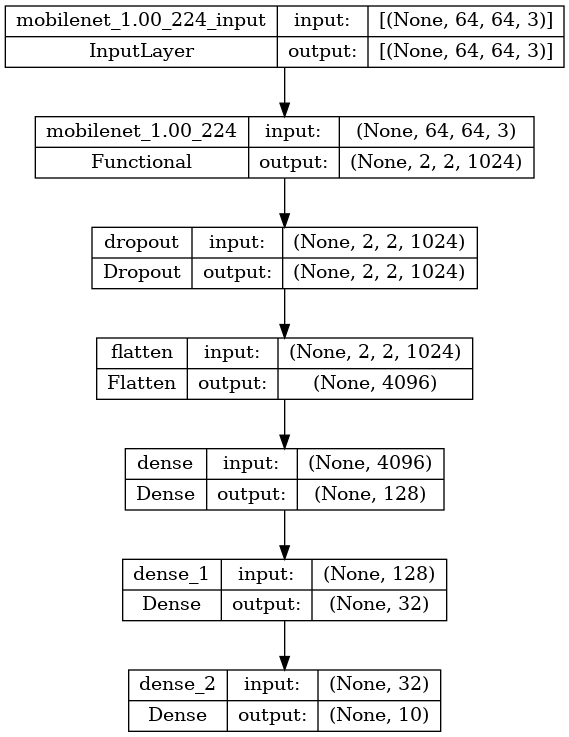

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.000005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

In [ ]:
history = model.fit(
    ds_train,
    epochs=100,
    validation_data=ds_validation,
    callbacks = tf.keras.callbacks.ModelCheckpoint(
        "MobileNet/MobileNet epoch:{epoch:02d}-val_loss:{val_loss:.3f}",
        save_best_only = True,
    )
)

Epoch 1/100


2022-11-19 18:30:35.761873: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-19 18:30:36.473854: W tensorflow/core/common_runtime/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


169/169 [==============================] - ETA: 0s - loss: 6.1968 - sparse_categorical_accuracy: 0.1151

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:01-val_loss:2.413/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:01-val_loss:2.413/assets


169/169 [==============================] - 21s 94ms/step - loss: 6.1968 - sparse_categorical_accuracy: 0.1151 - val_loss: 2.4126 - val_sparse_categorical_accuracy: 0.0959
Epoch 2/100
169/169 [==============================] - ETA: 0s - loss: 4.6422 - sparse_categorical_accuracy: 0.1403

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:02-val_loss:2.283/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:02-val_loss:2.283/assets


169/169 [==============================] - 15s 89ms/step - loss: 4.6422 - sparse_categorical_accuracy: 0.1403 - val_loss: 2.2832 - val_sparse_categorical_accuracy: 0.1830
Epoch 3/100
168/169 [============================>.] - ETA: 0s - loss: 3.7431 - sparse_categorical_accuracy: 0.1772

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:03-val_loss:1.964/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:03-val_loss:1.964/assets


169/169 [==============================] - 15s 88ms/step - loss: 3.7428 - sparse_categorical_accuracy: 0.1775 - val_loss: 1.9638 - val_sparse_categorical_accuracy: 0.2778
Epoch 4/100
169/169 [==============================] - ETA: 0s - loss: 3.2246 - sparse_categorical_accuracy: 0.2077

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:04-val_loss:1.815/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:04-val_loss:1.815/assets


169/169 [==============================] - 15s 89ms/step - loss: 3.2246 - sparse_categorical_accuracy: 0.2077 - val_loss: 1.8149 - val_sparse_categorical_accuracy: 0.3604
Epoch 5/100
169/169 [==============================] - ETA: 0s - loss: 2.8248 - sparse_categorical_accuracy: 0.2442

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:05-val_loss:1.713/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:05-val_loss:1.713/assets


169/169 [==============================] - 15s 89ms/step - loss: 2.8248 - sparse_categorical_accuracy: 0.2442 - val_loss: 1.7134 - val_sparse_categorical_accuracy: 0.4230
Epoch 6/100
168/169 [============================>.] - ETA: 0s - loss: 2.5169 - sparse_categorical_accuracy: 0.2824

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:06-val_loss:1.633/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:06-val_loss:1.633/assets


169/169 [==============================] - 15s 90ms/step - loss: 2.5166 - sparse_categorical_accuracy: 0.2824 - val_loss: 1.6334 - val_sparse_categorical_accuracy: 0.4656
Epoch 7/100
169/169 [==============================] - ETA: 0s - loss: 2.3028 - sparse_categorical_accuracy: 0.3206

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:07-val_loss:1.543/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:07-val_loss:1.543/assets


169/169 [==============================] - 15s 90ms/step - loss: 2.3028 - sparse_categorical_accuracy: 0.3206 - val_loss: 1.5427 - val_sparse_categorical_accuracy: 0.5026
Epoch 8/100
169/169 [==============================] - ETA: 0s - loss: 2.1088 - sparse_categorical_accuracy: 0.3572

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:08-val_loss:1.452/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:08-val_loss:1.452/assets


169/169 [==============================] - 15s 89ms/step - loss: 2.1088 - sparse_categorical_accuracy: 0.3572 - val_loss: 1.4520 - val_sparse_categorical_accuracy: 0.5296
Epoch 9/100
168/169 [============================>.] - ETA: 0s - loss: 1.9411 - sparse_categorical_accuracy: 0.4060

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:09-val_loss:1.359/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:09-val_loss:1.359/assets


169/169 [==============================] - 15s 90ms/step - loss: 1.9427 - sparse_categorical_accuracy: 0.4057 - val_loss: 1.3595 - val_sparse_categorical_accuracy: 0.5619
Epoch 10/100
169/169 [==============================] - ETA: 0s - loss: 1.8083 - sparse_categorical_accuracy: 0.4412

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:10-val_loss:1.271/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:10-val_loss:1.271/assets


169/169 [==============================] - 15s 89ms/step - loss: 1.8083 - sparse_categorical_accuracy: 0.4412 - val_loss: 1.2706 - val_sparse_categorical_accuracy: 0.5907
Epoch 11/100
168/169 [============================>.] - ETA: 0s - loss: 1.6536 - sparse_categorical_accuracy: 0.4808

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:11-val_loss:1.181/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:11-val_loss:1.181/assets


169/169 [==============================] - 15s 90ms/step - loss: 1.6550 - sparse_categorical_accuracy: 0.4806 - val_loss: 1.1806 - val_sparse_categorical_accuracy: 0.6185
Epoch 12/100
169/169 [==============================] - ETA: 0s - loss: 1.5506 - sparse_categorical_accuracy: 0.5125

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:12-val_loss:1.098/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:12-val_loss:1.098/assets


169/169 [==============================] - 15s 90ms/step - loss: 1.5506 - sparse_categorical_accuracy: 0.5125 - val_loss: 1.0981 - val_sparse_categorical_accuracy: 0.6537
Epoch 13/100
168/169 [============================>.] - ETA: 0s - loss: 1.4074 - sparse_categorical_accuracy: 0.5538

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:13-val_loss:1.021/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:13-val_loss:1.021/assets


169/169 [==============================] - 15s 89ms/step - loss: 1.4069 - sparse_categorical_accuracy: 0.5538 - val_loss: 1.0213 - val_sparse_categorical_accuracy: 0.6752
Epoch 14/100
168/169 [============================>.] - ETA: 0s - loss: 1.3439 - sparse_categorical_accuracy: 0.5728

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:14-val_loss:0.948/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:14-val_loss:0.948/assets


169/169 [==============================] - 15s 89ms/step - loss: 1.3444 - sparse_categorical_accuracy: 0.5728 - val_loss: 0.9484 - val_sparse_categorical_accuracy: 0.7004
Epoch 15/100
168/169 [============================>.] - ETA: 0s - loss: 1.2541 - sparse_categorical_accuracy: 0.5990

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:15-val_loss:0.888/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:15-val_loss:0.888/assets


169/169 [==============================] - 15s 89ms/step - loss: 1.2540 - sparse_categorical_accuracy: 0.5990 - val_loss: 0.8877 - val_sparse_categorical_accuracy: 0.7233
Epoch 16/100
169/169 [==============================] - ETA: 0s - loss: 1.1698 - sparse_categorical_accuracy: 0.6246

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:16-val_loss:0.829/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:16-val_loss:0.829/assets


169/169 [==============================] - 15s 91ms/step - loss: 1.1698 - sparse_categorical_accuracy: 0.6246 - val_loss: 0.8289 - val_sparse_categorical_accuracy: 0.7437
Epoch 17/100
169/169 [==============================] - ETA: 0s - loss: 1.1258 - sparse_categorical_accuracy: 0.6383

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:17-val_loss:0.778/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:17-val_loss:0.778/assets


169/169 [==============================] - 15s 90ms/step - loss: 1.1258 - sparse_categorical_accuracy: 0.6383 - val_loss: 0.7784 - val_sparse_categorical_accuracy: 0.7585
Epoch 18/100
168/169 [============================>.] - ETA: 0s - loss: 1.0625 - sparse_categorical_accuracy: 0.6610

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:18-val_loss:0.731/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:18-val_loss:0.731/assets


169/169 [==============================] - 15s 89ms/step - loss: 1.0624 - sparse_categorical_accuracy: 0.6610 - val_loss: 0.7308 - val_sparse_categorical_accuracy: 0.7733
Epoch 19/100
168/169 [============================>.] - ETA: 0s - loss: 0.9784 - sparse_categorical_accuracy: 0.6856

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:19-val_loss:0.689/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:19-val_loss:0.689/assets


169/169 [==============================] - 15s 90ms/step - loss: 0.9775 - sparse_categorical_accuracy: 0.6858 - val_loss: 0.6889 - val_sparse_categorical_accuracy: 0.7904
Epoch 20/100
168/169 [============================>.] - ETA: 0s - loss: 0.9349 - sparse_categorical_accuracy: 0.6993

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:20-val_loss:0.652/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:20-val_loss:0.652/assets


169/169 [==============================] - 15s 89ms/step - loss: 0.9352 - sparse_categorical_accuracy: 0.6992 - val_loss: 0.6523 - val_sparse_categorical_accuracy: 0.8048
Epoch 21/100
168/169 [============================>.] - ETA: 0s - loss: 0.8854 - sparse_categorical_accuracy: 0.7167

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:21-val_loss:0.619/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:21-val_loss:0.619/assets


169/169 [==============================] - 15s 90ms/step - loss: 0.8850 - sparse_categorical_accuracy: 0.7169 - val_loss: 0.6192 - val_sparse_categorical_accuracy: 0.8137
Epoch 22/100
169/169 [==============================] - ETA: 0s - loss: 0.8374 - sparse_categorical_accuracy: 0.7319

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:22-val_loss:0.587/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:22-val_loss:0.587/assets


169/169 [==============================] - 15s 90ms/step - loss: 0.8374 - sparse_categorical_accuracy: 0.7319 - val_loss: 0.5869 - val_sparse_categorical_accuracy: 0.8237
Epoch 23/100
168/169 [============================>.] - ETA: 0s - loss: 0.7895 - sparse_categorical_accuracy: 0.7429

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:23-val_loss:0.559/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:23-val_loss:0.559/assets


169/169 [==============================] - 15s 89ms/step - loss: 0.7882 - sparse_categorical_accuracy: 0.7433 - val_loss: 0.5593 - val_sparse_categorical_accuracy: 0.8344
Epoch 24/100
168/169 [============================>.] - ETA: 0s - loss: 0.7520 - sparse_categorical_accuracy: 0.7601

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:24-val_loss:0.533/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:24-val_loss:0.533/assets


169/169 [==============================] - 15s 91ms/step - loss: 0.7525 - sparse_categorical_accuracy: 0.7600 - val_loss: 0.5327 - val_sparse_categorical_accuracy: 0.8444
Epoch 25/100
169/169 [==============================] - ETA: 0s - loss: 0.7262 - sparse_categorical_accuracy: 0.7672

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:25-val_loss:0.506/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:25-val_loss:0.506/assets


169/169 [==============================] - 15s 90ms/step - loss: 0.7262 - sparse_categorical_accuracy: 0.7672 - val_loss: 0.5058 - val_sparse_categorical_accuracy: 0.8526
Epoch 26/100
168/169 [============================>.] - ETA: 0s - loss: 0.6929 - sparse_categorical_accuracy: 0.7772

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:26-val_loss:0.486/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:26-val_loss:0.486/assets


169/169 [==============================] - 15s 90ms/step - loss: 0.6925 - sparse_categorical_accuracy: 0.7772 - val_loss: 0.4859 - val_sparse_categorical_accuracy: 0.8567
Epoch 27/100
168/169 [============================>.] - ETA: 0s - loss: 0.6527 - sparse_categorical_accuracy: 0.7898

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:27-val_loss:0.467/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:27-val_loss:0.467/assets


169/169 [==============================] - 15s 90ms/step - loss: 0.6542 - sparse_categorical_accuracy: 0.7895 - val_loss: 0.4673 - val_sparse_categorical_accuracy: 0.8607
Epoch 28/100
169/169 [==============================] - ETA: 0s - loss: 0.6233 - sparse_categorical_accuracy: 0.8013

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:28-val_loss:0.448/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:28-val_loss:0.448/assets


169/169 [==============================] - 15s 91ms/step - loss: 0.6233 - sparse_categorical_accuracy: 0.8013 - val_loss: 0.4475 - val_sparse_categorical_accuracy: 0.8689
Epoch 29/100
168/169 [============================>.] - ETA: 0s - loss: 0.5966 - sparse_categorical_accuracy: 0.8097

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:29-val_loss:0.431/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:29-val_loss:0.431/assets


169/169 [==============================] - 15s 91ms/step - loss: 0.5971 - sparse_categorical_accuracy: 0.8098 - val_loss: 0.4307 - val_sparse_categorical_accuracy: 0.8744
Epoch 30/100
169/169 [==============================] - ETA: 0s - loss: 0.5754 - sparse_categorical_accuracy: 0.8192

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:30-val_loss:0.415/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:30-val_loss:0.415/assets


169/169 [==============================] - 15s 92ms/step - loss: 0.5754 - sparse_categorical_accuracy: 0.8192 - val_loss: 0.4147 - val_sparse_categorical_accuracy: 0.8785
Epoch 31/100
168/169 [============================>.] - ETA: 0s - loss: 0.5455 - sparse_categorical_accuracy: 0.8268

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:31-val_loss:0.400/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:31-val_loss:0.400/assets


169/169 [==============================] - 15s 91ms/step - loss: 0.5464 - sparse_categorical_accuracy: 0.8267 - val_loss: 0.4001 - val_sparse_categorical_accuracy: 0.8830
Epoch 32/100
168/169 [============================>.] - ETA: 0s - loss: 0.5294 - sparse_categorical_accuracy: 0.8308

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:32-val_loss:0.388/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:32-val_loss:0.388/assets


169/169 [==============================] - 15s 90ms/step - loss: 0.5297 - sparse_categorical_accuracy: 0.8308 - val_loss: 0.3879 - val_sparse_categorical_accuracy: 0.8863
Epoch 33/100
168/169 [============================>.] - ETA: 0s - loss: 0.5125 - sparse_categorical_accuracy: 0.8382

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:33-val_loss:0.375/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:33-val_loss:0.375/assets


169/169 [==============================] - 15s 90ms/step - loss: 0.5122 - sparse_categorical_accuracy: 0.8382 - val_loss: 0.3748 - val_sparse_categorical_accuracy: 0.8889
Epoch 34/100
168/169 [============================>.] - ETA: 0s - loss: 0.4874 - sparse_categorical_accuracy: 0.8462

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:34-val_loss:0.366/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:34-val_loss:0.366/assets


169/169 [==============================] - 15s 89ms/step - loss: 0.4875 - sparse_categorical_accuracy: 0.8463 - val_loss: 0.3655 - val_sparse_categorical_accuracy: 0.8896
Epoch 35/100
169/169 [==============================] - ETA: 0s - loss: 0.4770 - sparse_categorical_accuracy: 0.8506

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:35-val_loss:0.355/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:35-val_loss:0.355/assets


169/169 [==============================] - 15s 89ms/step - loss: 0.4770 - sparse_categorical_accuracy: 0.8506 - val_loss: 0.3546 - val_sparse_categorical_accuracy: 0.8933
Epoch 36/100
168/169 [============================>.] - ETA: 0s - loss: 0.4525 - sparse_categorical_accuracy: 0.8557

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:36-val_loss:0.344/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:36-val_loss:0.344/assets


169/169 [==============================] - 15s 89ms/step - loss: 0.4519 - sparse_categorical_accuracy: 0.8557 - val_loss: 0.3437 - val_sparse_categorical_accuracy: 0.8963
Epoch 37/100
169/169 [==============================] - ETA: 0s - loss: 0.4366 - sparse_categorical_accuracy: 0.8637

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:37-val_loss:0.335/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:37-val_loss:0.335/assets


169/169 [==============================] - 15s 90ms/step - loss: 0.4366 - sparse_categorical_accuracy: 0.8637 - val_loss: 0.3349 - val_sparse_categorical_accuracy: 0.8996
Epoch 38/100
168/169 [============================>.] - ETA: 0s - loss: 0.4159 - sparse_categorical_accuracy: 0.8688

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:38-val_loss:0.327/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:38-val_loss:0.327/assets


169/169 [==============================] - 15s 89ms/step - loss: 0.4161 - sparse_categorical_accuracy: 0.8687 - val_loss: 0.3266 - val_sparse_categorical_accuracy: 0.9004
Epoch 39/100
169/169 [==============================] - ETA: 0s - loss: 0.3987 - sparse_categorical_accuracy: 0.8731

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:39-val_loss:0.318/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:39-val_loss:0.318/assets


169/169 [==============================] - 15s 89ms/step - loss: 0.3987 - sparse_categorical_accuracy: 0.8731 - val_loss: 0.3178 - val_sparse_categorical_accuracy: 0.9033
Epoch 40/100
168/169 [============================>.] - ETA: 0s - loss: 0.3918 - sparse_categorical_accuracy: 0.8776

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:40-val_loss:0.311/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:40-val_loss:0.311/assets


169/169 [==============================] - 15s 89ms/step - loss: 0.3924 - sparse_categorical_accuracy: 0.8775 - val_loss: 0.3109 - val_sparse_categorical_accuracy: 0.9030
Epoch 41/100
169/169 [==============================] - ETA: 0s - loss: 0.3904 - sparse_categorical_accuracy: 0.8805

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:41-val_loss:0.303/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:41-val_loss:0.303/assets


169/169 [==============================] - 15s 89ms/step - loss: 0.3904 - sparse_categorical_accuracy: 0.8805 - val_loss: 0.3028 - val_sparse_categorical_accuracy: 0.9052
Epoch 42/100
169/169 [==============================] - ETA: 0s - loss: 0.3664 - sparse_categorical_accuracy: 0.8845

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:42-val_loss:0.298/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:42-val_loss:0.298/assets


169/169 [==============================] - 15s 90ms/step - loss: 0.3664 - sparse_categorical_accuracy: 0.8845 - val_loss: 0.2981 - val_sparse_categorical_accuracy: 0.9070
Epoch 43/100
169/169 [==============================] - ETA: 0s - loss: 0.3562 - sparse_categorical_accuracy: 0.8874

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:43-val_loss:0.291/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:43-val_loss:0.291/assets


169/169 [==============================] - 15s 90ms/step - loss: 0.3562 - sparse_categorical_accuracy: 0.8874 - val_loss: 0.2909 - val_sparse_categorical_accuracy: 0.9122
Epoch 44/100
168/169 [============================>.] - ETA: 0s - loss: 0.3426 - sparse_categorical_accuracy: 0.8904

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:44-val_loss:0.284/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:44-val_loss:0.284/assets


169/169 [==============================] - 15s 89ms/step - loss: 0.3425 - sparse_categorical_accuracy: 0.8906 - val_loss: 0.2842 - val_sparse_categorical_accuracy: 0.9144
Epoch 45/100
169/169 [==============================] - ETA: 0s - loss: 0.3330 - sparse_categorical_accuracy: 0.8941

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:45-val_loss:0.279/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:45-val_loss:0.279/assets


169/169 [==============================] - 15s 89ms/step - loss: 0.3330 - sparse_categorical_accuracy: 0.8941 - val_loss: 0.2794 - val_sparse_categorical_accuracy: 0.9144
Epoch 46/100
168/169 [============================>.] - ETA: 0s - loss: 0.3291 - sparse_categorical_accuracy: 0.8976

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:46-val_loss:0.273/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:46-val_loss:0.273/assets


169/169 [==============================] - 15s 89ms/step - loss: 0.3295 - sparse_categorical_accuracy: 0.8978 - val_loss: 0.2732 - val_sparse_categorical_accuracy: 0.9170
Epoch 47/100
169/169 [==============================] - ETA: 0s - loss: 0.3107 - sparse_categorical_accuracy: 0.9028

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:47-val_loss:0.269/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:47-val_loss:0.269/assets


169/169 [==============================] - 15s 90ms/step - loss: 0.3107 - sparse_categorical_accuracy: 0.9028 - val_loss: 0.2692 - val_sparse_categorical_accuracy: 0.9189
Epoch 48/100
168/169 [============================>.] - ETA: 0s - loss: 0.3046 - sparse_categorical_accuracy: 0.9054

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:48-val_loss:0.266/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:48-val_loss:0.266/assets


169/169 [==============================] - 15s 89ms/step - loss: 0.3043 - sparse_categorical_accuracy: 0.9055 - val_loss: 0.2655 - val_sparse_categorical_accuracy: 0.9189
Epoch 49/100
169/169 [==============================] - ETA: 0s - loss: 0.2972 - sparse_categorical_accuracy: 0.9080

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:49-val_loss:0.261/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:49-val_loss:0.261/assets


169/169 [==============================] - 15s 91ms/step - loss: 0.2972 - sparse_categorical_accuracy: 0.9080 - val_loss: 0.2614 - val_sparse_categorical_accuracy: 0.9204
Epoch 50/100
169/169 [==============================] - ETA: 0s - loss: 0.2930 - sparse_categorical_accuracy: 0.9072

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:50-val_loss:0.258/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:50-val_loss:0.258/assets


169/169 [==============================] - 15s 91ms/step - loss: 0.2930 - sparse_categorical_accuracy: 0.9072 - val_loss: 0.2584 - val_sparse_categorical_accuracy: 0.9200
Epoch 51/100
168/169 [============================>.] - ETA: 0s - loss: 0.2746 - sparse_categorical_accuracy: 0.9112

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:51-val_loss:0.255/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:51-val_loss:0.255/assets


169/169 [==============================] - 15s 89ms/step - loss: 0.2743 - sparse_categorical_accuracy: 0.9112 - val_loss: 0.2547 - val_sparse_categorical_accuracy: 0.9211
Epoch 52/100
168/169 [============================>.] - ETA: 0s - loss: 0.2703 - sparse_categorical_accuracy: 0.9150

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:52-val_loss:0.248/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:52-val_loss:0.248/assets


169/169 [==============================] - 15s 90ms/step - loss: 0.2707 - sparse_categorical_accuracy: 0.9148 - val_loss: 0.2482 - val_sparse_categorical_accuracy: 0.9226
Epoch 53/100
168/169 [============================>.] - ETA: 0s - loss: 0.2636 - sparse_categorical_accuracy: 0.9189

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:53-val_loss:0.245/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:53-val_loss:0.245/assets


169/169 [==============================] - 15s 90ms/step - loss: 0.2634 - sparse_categorical_accuracy: 0.9189 - val_loss: 0.2450 - val_sparse_categorical_accuracy: 0.9256
Epoch 54/100
168/169 [============================>.] - ETA: 0s - loss: 0.2502 - sparse_categorical_accuracy: 0.9230

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:54-val_loss:0.241/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:54-val_loss:0.241/assets


169/169 [==============================] - 15s 91ms/step - loss: 0.2505 - sparse_categorical_accuracy: 0.9229 - val_loss: 0.2411 - val_sparse_categorical_accuracy: 0.9259
Epoch 55/100
169/169 [==============================] - ETA: 0s - loss: 0.2515 - sparse_categorical_accuracy: 0.9219

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:55-val_loss:0.238/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:55-val_loss:0.238/assets


169/169 [==============================] - 15s 90ms/step - loss: 0.2515 - sparse_categorical_accuracy: 0.9219 - val_loss: 0.2379 - val_sparse_categorical_accuracy: 0.9281
Epoch 56/100
169/169 [==============================] - ETA: 0s - loss: 0.2430 - sparse_categorical_accuracy: 0.9252

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:56-val_loss:0.235/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:56-val_loss:0.235/assets


169/169 [==============================] - 15s 90ms/step - loss: 0.2430 - sparse_categorical_accuracy: 0.9252 - val_loss: 0.2351 - val_sparse_categorical_accuracy: 0.9281
Epoch 57/100
169/169 [==============================] - ETA: 0s - loss: 0.2310 - sparse_categorical_accuracy: 0.9276

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:57-val_loss:0.232/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:57-val_loss:0.232/assets


169/169 [==============================] - 15s 90ms/step - loss: 0.2310 - sparse_categorical_accuracy: 0.9276 - val_loss: 0.2324 - val_sparse_categorical_accuracy: 0.9281
Epoch 58/100
168/169 [============================>.] - ETA: 0s - loss: 0.2302 - sparse_categorical_accuracy: 0.9286

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:58-val_loss:0.231/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:58-val_loss:0.231/assets


169/169 [==============================] - 15s 90ms/step - loss: 0.2300 - sparse_categorical_accuracy: 0.9286 - val_loss: 0.2314 - val_sparse_categorical_accuracy: 0.9281
Epoch 59/100
169/169 [==============================] - ETA: 0s - loss: 0.2223 - sparse_categorical_accuracy: 0.9308

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:59-val_loss:0.228/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:59-val_loss:0.228/assets


169/169 [==============================] - 15s 90ms/step - loss: 0.2223 - sparse_categorical_accuracy: 0.9308 - val_loss: 0.2282 - val_sparse_categorical_accuracy: 0.9293
Epoch 60/100
168/169 [============================>.] - ETA: 0s - loss: 0.2103 - sparse_categorical_accuracy: 0.9324

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:60-val_loss:0.227/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:60-val_loss:0.227/assets


169/169 [==============================] - 15s 90ms/step - loss: 0.2101 - sparse_categorical_accuracy: 0.9325 - val_loss: 0.2274 - val_sparse_categorical_accuracy: 0.9293
Epoch 61/100
169/169 [==============================] - ETA: 0s - loss: 0.2117 - sparse_categorical_accuracy: 0.9318

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:61-val_loss:0.226/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:61-val_loss:0.226/assets


169/169 [==============================] - 15s 91ms/step - loss: 0.2117 - sparse_categorical_accuracy: 0.9318 - val_loss: 0.2259 - val_sparse_categorical_accuracy: 0.9304
Epoch 62/100
169/169 [==============================] - ETA: 0s - loss: 0.2092 - sparse_categorical_accuracy: 0.9341

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:62-val_loss:0.222/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:62-val_loss:0.222/assets


169/169 [==============================] - 15s 90ms/step - loss: 0.2092 - sparse_categorical_accuracy: 0.9341 - val_loss: 0.2224 - val_sparse_categorical_accuracy: 0.9315
Epoch 63/100
168/169 [============================>.] - ETA: 0s - loss: 0.2055 - sparse_categorical_accuracy: 0.9350

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:63-val_loss:0.220/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:63-val_loss:0.220/assets


169/169 [==============================] - 15s 90ms/step - loss: 0.2055 - sparse_categorical_accuracy: 0.9351 - val_loss: 0.2201 - val_sparse_categorical_accuracy: 0.9333
Epoch 64/100
169/169 [==============================] - ETA: 0s - loss: 0.1961 - sparse_categorical_accuracy: 0.9374

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:64-val_loss:0.217/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:64-val_loss:0.217/assets


169/169 [==============================] - 15s 90ms/step - loss: 0.1961 - sparse_categorical_accuracy: 0.9374 - val_loss: 0.2167 - val_sparse_categorical_accuracy: 0.9330
Epoch 65/100
168/169 [============================>.] - ETA: 0s - loss: 0.1829 - sparse_categorical_accuracy: 0.9410

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:65-val_loss:0.215/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:65-val_loss:0.215/assets


169/169 [==============================] - 15s 90ms/step - loss: 0.1833 - sparse_categorical_accuracy: 0.9409 - val_loss: 0.2154 - val_sparse_categorical_accuracy: 0.9348
Epoch 66/100
168/169 [============================>.] - ETA: 0s - loss: 0.1831 - sparse_categorical_accuracy: 0.9433

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:66-val_loss:0.213/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:66-val_loss:0.213/assets


169/169 [==============================] - 15s 90ms/step - loss: 0.1834 - sparse_categorical_accuracy: 0.9432 - val_loss: 0.2127 - val_sparse_categorical_accuracy: 0.9359
Epoch 67/100
168/169 [============================>.] - ETA: 0s - loss: 0.1708 - sparse_categorical_accuracy: 0.9442

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:67-val_loss:0.211/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:67-val_loss:0.211/assets


169/169 [==============================] - 15s 91ms/step - loss: 0.1710 - sparse_categorical_accuracy: 0.9443 - val_loss: 0.2107 - val_sparse_categorical_accuracy: 0.9352
Epoch 68/100
169/169 [==============================] - ETA: 0s - loss: 0.1736 - sparse_categorical_accuracy: 0.9450

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:68-val_loss:0.210/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:68-val_loss:0.210/assets


169/169 [==============================] - 15s 90ms/step - loss: 0.1736 - sparse_categorical_accuracy: 0.9450 - val_loss: 0.2097 - val_sparse_categorical_accuracy: 0.9356
Epoch 69/100
168/169 [============================>.] - ETA: 0s - loss: 0.1664 - sparse_categorical_accuracy: 0.9470

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:69-val_loss:0.209/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:69-val_loss:0.209/assets


169/169 [==============================] - 15s 89ms/step - loss: 0.1663 - sparse_categorical_accuracy: 0.9471 - val_loss: 0.2087 - val_sparse_categorical_accuracy: 0.9363
Epoch 70/100
169/169 [==============================] - ETA: 0s - loss: 0.1619 - sparse_categorical_accuracy: 0.9472

INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:70-val_loss:0.207/assets


INFO:tensorflow:Assets written to: MobileNet/MobileNet epoch:70-val_loss:0.207/assets


169/169 [==============================] - 15s 90ms/step - loss: 0.1619 - sparse_categorical_accuracy: 0.9472 - val_loss: 0.2065 - val_sparse_categorical_accuracy: 0.9374
Epoch 71/100
147/169 [=========================>....] - ETA: 1s - loss: 0.1634 - sparse_categorical_accuracy: 0.9470

In [ ]:
test_loss, test_acc = model.evaluate(ds_test, verbose=0)
print('\nTest accuracy:', test_acc)


ds_test_predict = model.predict(ds_test, verbose=0)

labels_iterator = ds_test.unbatch().map(lambda x, y: y).as_numpy_iterator()
labels = np.array(list(labels_iterator))

y_pred = np.argmax(ds_test_predict, axis=1)
y_test = labels
plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y_pred, y_test, normalize="pred"), annot=True, fmt=".2%",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(['AnnualCrop','Forest','HerbaceousVegetation',
                         'Highway','Industrial','Pasture','PermanentCrop',
                         'Residential','River','SeaLake'], rotation=20, ha="right")
fx.yaxis.set_ticklabels(['AnnualCrop','Forest','HerbaceousVegetation',
                         'Highway','Industrial','Pasture','PermanentCrop',
                         'Residential','River','SeaLake'], rotation=20, ha="right")

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
plt.savefig(fname="MobileNet/MobileNet confusion matrix"+current_time,dpi=300)
render_training_history(history)
